In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fetal-head-ultrasound-dataset-for-image-segment:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3118209%2F5374586%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240324%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240324T123803Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dab595824df7b736ba45da55918a580e04d47f094c24605c74529a2a8c4e0a838b8c0dcc14947bc9cbd31698c9f8f5afd6cc2dc76d2cf7ffe3b534718ac44216026afef4f410b925f050cd3ef9ce6e0883616d961046028399b4945661285f766b994ff7670bc7fc8bc9619fbc021ed443d1ff469d1e9da8306f27e313f23632a564c56499d18c130c12af4d48998eca5629865a79a7792121ae58e8e2a8af2e8379dd1538b39bf2e5670e14c4873d0e1ed6f22c34729efc63bc45339034b28559f9a840f48dbd62b354aa21f65928398a45d598fe47c626f63282c025e5bca3648c7aa6d4b89260ad2759116685e4c67bcd33daa641443bca8c11ec05960979c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 176857059 bytes downloaded
Downloaded and uncompressed: fetal-head-ultrasound-dataset-for-image-segment
Data source import complete.


In [4]:
import os
path2train="/kaggle/input/fetal-head-ultrasound-dataset-for-image-segment/training_set/training_set"

imgsList = [pp for pp in os.listdir(path2train) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList))

number of images: 999
number of annotations: 999


In [5]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['817_HC.png', '874_2HC.png', '241_HC.png', '811_HC.png'],
      dtype='<U11')

In [6]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)


    img_mask=mark_boundaries(np.array(img),
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)

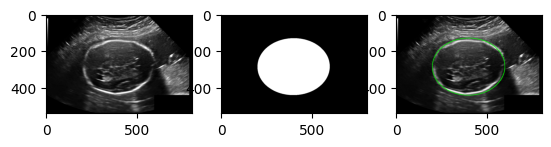

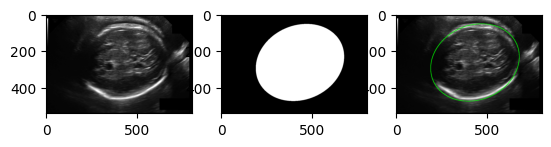

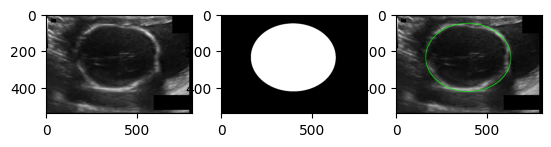

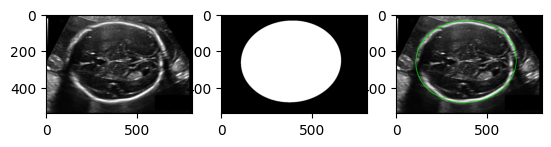

In [7]:
for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt= path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3)
    show_img_mask(img, mask)

(-0.5, 799.5, 539.5, -0.5)

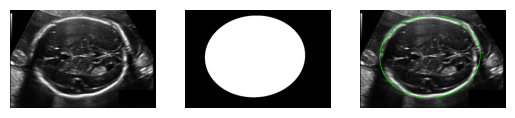

In [8]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 3)
show_img_mask(img, mask)
plt.axis('off')

In [9]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    Resize,
)

h,w=128,192
transform_train = Compose([ Resize(h,w),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
              ])


transform_val = Resize(h,w)

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torchvision.transforms.functional import to_tensor, to_pil_image

class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None):

        imgsList = [pp for pp in os.listdir(path2data) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
        anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]

        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList]
        self.path2annts= [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]

        self.transform = transform

    def __len__(self):
        return len(self.path2imgs)

    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)

        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)

        image= np.array(image)
        mask=mask.astype("uint8")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image= to_tensor(image)
        mask=255*to_tensor(mask)
        return image, mask

In [12]:
fetal_ds1=fetal_dataset(path2train, transform=transform_train)
fetal_ds2=fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


In [13]:
img,mask=fetal_ds1[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


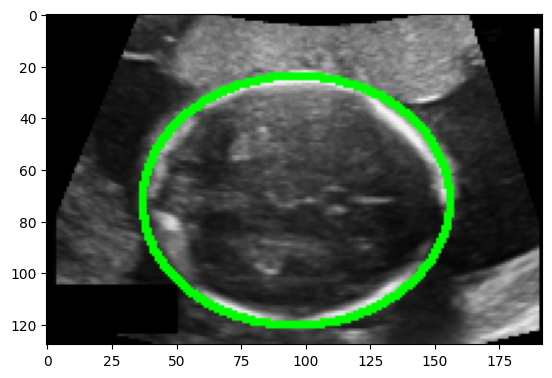

In [14]:
show_img_mask(img, mask)

In [15]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

799
----------
200


In [16]:
from torch.utils.data import Subset

train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))

val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))

799
200


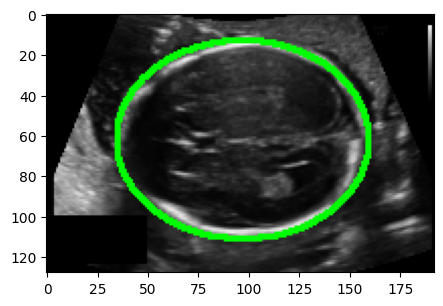

In [17]:
plt.figure(figsize=(5,5))
for img,mask in train_ds:
    show_img_mask(img,mask)
    break

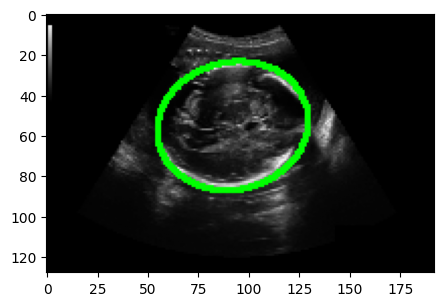

In [18]:
plt.figure(figsize=(5,5))
for img,mask in val_ds:
    show_img_mask(img,mask)
    break

In [19]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, pin_memory=True)

In [20]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([4, 1, 128, 192]) torch.float32
torch.Size([4, 1, 128, 192]) torch.float32


In [21]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [22]:
torch.max(img_b)

tensor(0.9804)

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()

        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"]
        num_outputs=params["num_outputs"]

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv5(x)
        x = F.relu(x)

        x=self.upsample(x)
        x = self.conv_up1(x)
        x = F.relu(x)

        x=self.upsample(x)
        x = self.conv_up2(x)
        x = F.relu(x)

        x=self.upsample(x)
        x = self.conv_up3(x)
        x = F.relu(x)

        x=self.upsample(x)
        x = self.conv_up4(x)
        x = F.relu(x)

        x = self.conv_out(x)

        return x

In [25]:
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16,
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [26]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [27]:
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [28]:
!pip install torchsummary

In [29]:
from torchsummary import summary
summary(model, input_size=(1, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

In [30]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3))

    dice= 2.0 * (intersection + smooth) / (union+ smooth)
    loss = 1.0 - dice

    return loss.sum(), dice.sum()

In [31]:
import torch.nn.functional as F

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')

    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)

    loss = bce  + dlv

    return loss

In [32]:
for img_v,mask_v in val_dl:
    mask_v= mask_v[8:]
    break

for img_t,mask_t in train_dl:
    break



print(dice_loss(mask_v,mask_v))
loss_func(mask_v,torch.zeros_like(mask_v))

(tensor(0.), tensor(0.))


tensor(0.)

In [33]:
import torchvision

def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)

    return metric

In [34]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)

    with torch.no_grad():
        pred= torch.sigmoid(output)
        _, metric_b=dice_loss(pred, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [35]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

In [36]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [37]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [38]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)

        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break

    loss=running_loss/float(len_data)

    metric=running_metric/float(len_data)

    return loss, metric

In [39]:
import copy
import time
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": []}

    metric_history={
        "train": [],
        "val": []}


    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

        start_time = time.time()

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        epoch_time = time.time() - start_time
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("Epoch Time: %.2f seconds".format(epoch_time))
        print("-"*10)


    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [40]:
opt = optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 50,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/49, current lr=0.0003
Copied best model weights!
train loss: 10079.453208, dice: 51.20
val loss: 7165.678926, dice: 65.61
Epoch Time: %.2f seconds
----------
Epoch 1/49, current lr=0.0003
Copied best model weights!
train loss: 6276.018111, dice: 71.12
val loss: 4989.640283, dice: 75.08
Epoch Time: %.2f seconds
----------
Epoch 2/49, current lr=0.0003
Copied best model weights!
train loss: 4554.235279, dice: 77.61
val loss: 4138.965430, dice: 76.96
Epoch Time: %.2f seconds
----------
Epoch 3/49, current lr=0.0003
Copied best model weights!
train loss: 3422.790430, dice: 82.67
val loss: 3016.824360, dice: 84.10
Epoch Time: %.2f seconds
----------
Epoch 4/49, current lr=0.0003
Copied best model weights!
train loss: 2708.151808, dice: 86.13
val loss: 2591.184531, dice: 87.08
Epoch Time: %.2f seconds
----------
Epoch 5/49, current lr=0.0003
Copied best model weights!
train loss: 2362.857564, dice: 88.14
val loss: 2272.226035, dice: 88.10
Epoch Time: %.2f seconds
----------
Epoch 6/4

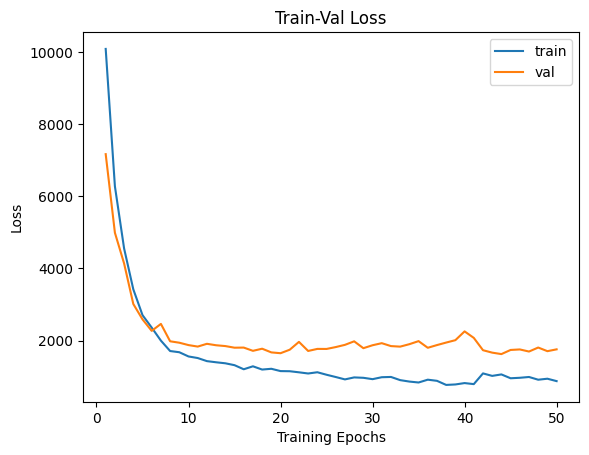

In [41]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

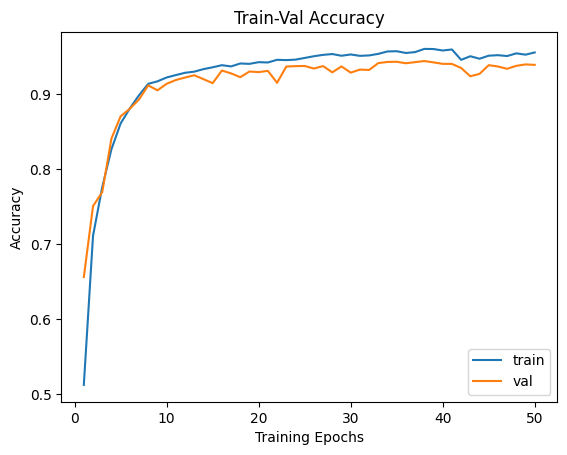

In [42]:
# Chuyển các tensors trong list về CPU và chuyển chúng thành mảng NumPy (nếu cần)
train_acc = [t.cpu().numpy() if t.is_cuda else t.numpy() for t in metric_hist["train"]]
val_acc = [t.cpu().numpy() if t.is_cuda else t.numpy() for t in metric_hist["val"]]

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), train_acc, label="train")
plt.plot(range(1, num_epochs+1), val_acc, label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [43]:
import os
path2test="/kaggle/input/fetal-head-ultrasound-dataset-for-image-segment/test_set/test_set"
imgsList=[pp for pp in os.listdir(path2test) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
print("number of images:", len(imgsList))

number of images: 335


In [44]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['77_HC.png', '277_HC.png', '80_HC.png', '202_2HC.png'],
      dtype='<U11')

In [45]:
path2weights="/kaggle/working/models/weights.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/models/weights.pt'

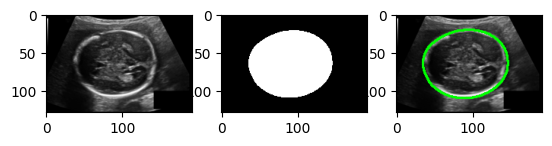

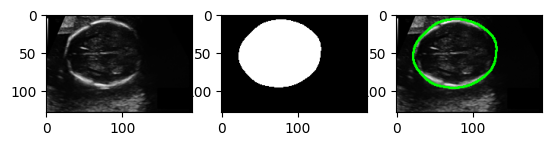

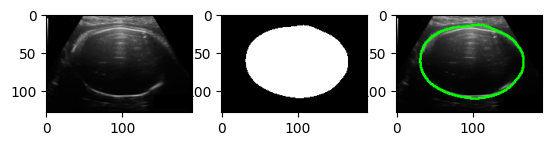

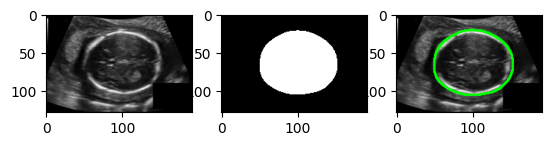

In [46]:
from torchvision.transforms.functional import to_tensor, to_pil_image

for fn in rndImgs:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img=img.resize((w,h))
    img_t=to_tensor(img).unsqueeze(0).to(device)

    #model(img_test.unsqueeze(0).cuda()).cpu()

    pred = model(img_t).cpu()

    pred=torch.sigmoid(pred)[0]
    mask_pred= (pred[0]>=0.5)

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred, cmap="gray")

    plt.subplot(1, 3, 3)
    show_img_mask(img, mask_pred)

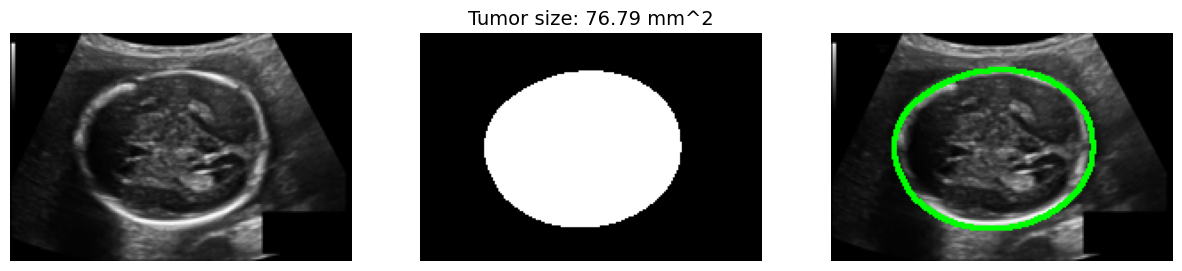

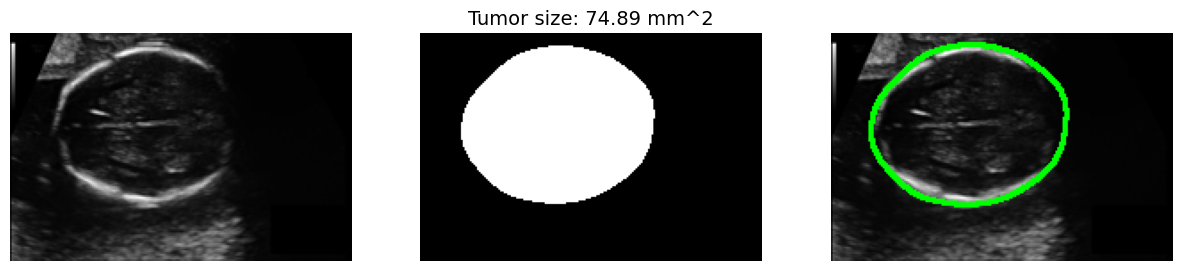

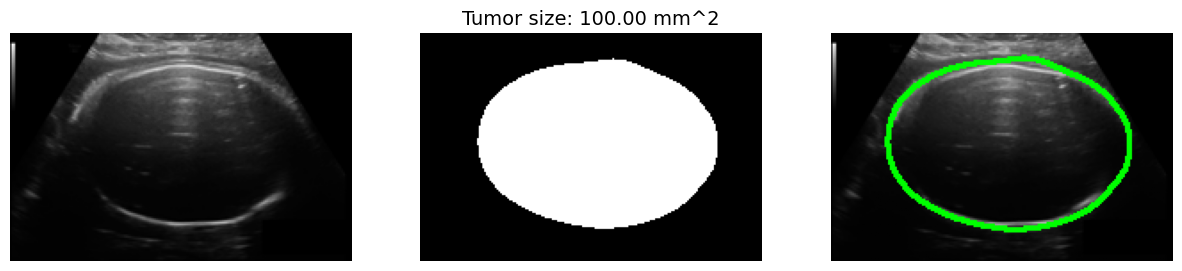

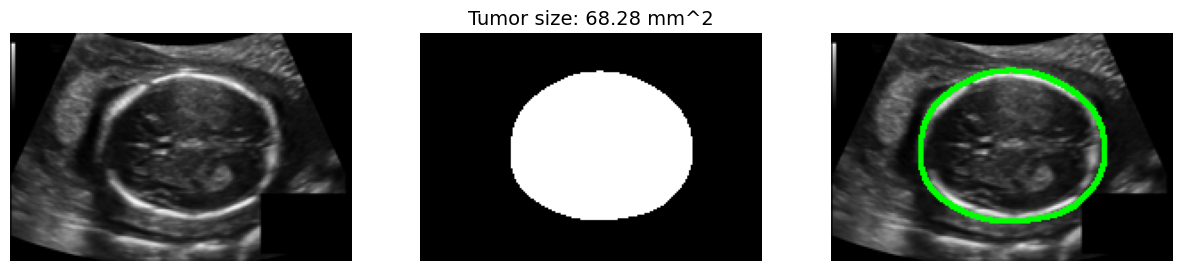

In [47]:
import skimage.filters
import skimage.measure

for fn in rndImgs:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img = img.resize((w, h))
    img_t = to_tensor(img).unsqueeze(0).to(device)

    pred = model(img_t).cpu()
    pred = torch.sigmoid(pred)[0]
    mask_pred = (pred[0] >= 0.5)

    image_gray = mask_pred.numpy().astype('uint8') * 255  # Convert the mask to grayscale

    thresh = skimage.filters.threshold_otsu(image_gray)
    tumor_mask = image_gray > thresh

    pixel_size = 0.1  # the size of a pixel in millimeters
    label_image = skimage.measure.label(tumor_mask)
    region_props = skimage.measure.regionprops(label_image)

    if len(region_props) == 0:
        tumor_size_mm = 0.0
    else:
        tumor_area = region_props[0].area
        tumor_size_mm = tumor_area * pixel_size ** 2

    plt.figure(figsize=(15, 5))  # Set the figure size to (15, 5)

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Tumor size: {tumor_size_mm:.2f} mm^2", fontsize=14)  # Display the tumor size on the plot
    plt.imshow(mask_pred, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    show_img_mask(img, mask_pred)
    plt.axis('off')

    plt.show()


In [49]:
import torch
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader
import numpy as np

# Khởi tạo DataLoader, mô hình, và thiết bị
# val_dl = DataLoader(...)
# model = YourModel(...)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Khởi tạo danh sách để lưu trữ nhãn thực tế và dự đoán
y_true = []
y_pred = []

# Không cần tính gradient trong quá trình đánh giá
with torch.no_grad():
    for inputs, labels in val_dl:
        # Chuyển dữ liệu vào cùng một thiết bị với mô hình
        inputs, labels = inputs.to(device), labels.to(device)

        # Tính toán dự đoán của mô hình
        outputs = model(inputs)

        # Làm phẳng output và labels để tính MAE
        # Bỏ qua chiều batch và chỉ giữ lại phần dự đoán
        y_pred.extend(outputs.detach().cpu().numpy().flatten())
        y_true.extend(labels.detach().cpu().numpy().flatten())

# Chuyển các danh sách sang numpy arrays để tính toán MAE
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Tính MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 11.483233451843262
